In [221]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

In [222]:
df = pd.read_csv('ita_values.csv')
df[df['ita_kmeans'] == -99] = np.nan
df = df.dropna()

df['light'] = df['file'].apply(lambda x: x.split('/')[-3])
df['mel'] = df['mel'].astype(float)

df.head()

,file,mel,ita_ssynth,ita_kmeans,ita_bevan,light
0,data/output_10k/output/skin_010/hairModel_098/...,0.45,16.868658,17.206573,-17.073883,light_hospital_room_4k
1,data/output_10k/output/skin_010/hairModel_098/...,0.19,36.809139,37.349349,43.650122,light_comfy_cafe_4k
2,data/output_10k/output/skin_010/hairModel_030/...,0.10,29.744881,27.462562,37.698597,light_yaris_interior_garage_4k
3,data/output_10k/output/skin_010/hairModel_030/...,0.14,26.291565,27.101764,19.647195,light_school_hall_4k
4,data/output_10k/output/skin_010/hairModel_030/...,0.29,27.309110,28.610460,7.758196,light_bathroom_4k


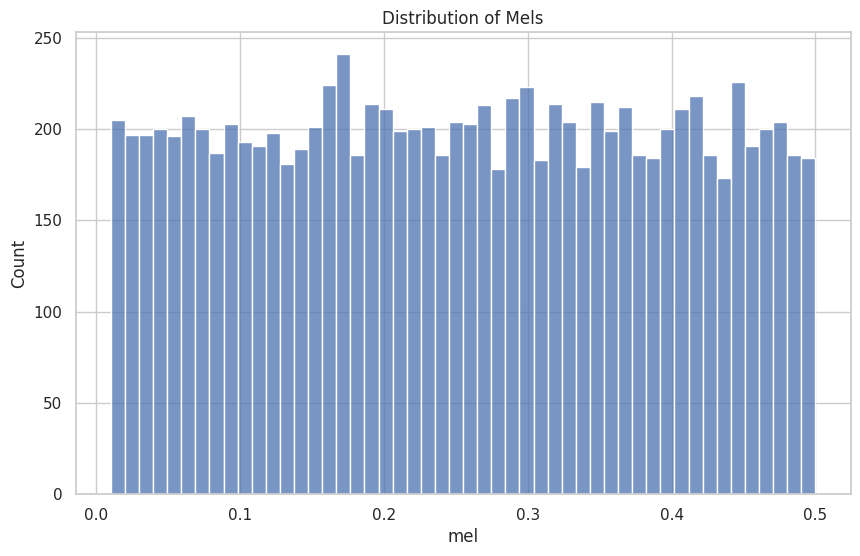

In [223]:
# plot the distribution of mels
plt.figure(figsize=(10, 6))
sns.histplot(df['mel'], bins=50)
plt.title('Distribution of Mels')
plt.show()

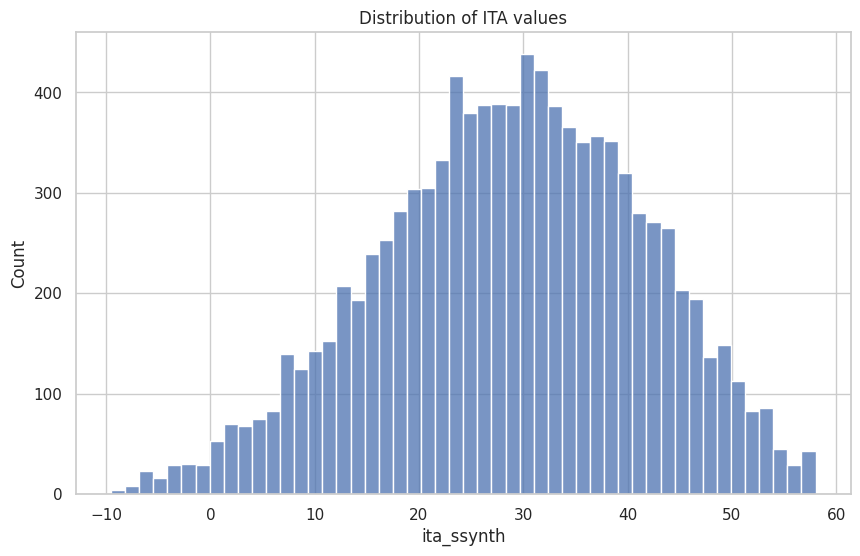

In [224]:
# distribution of ITA values
plt.figure(figsize=(10, 6))
sns.histplot(df['ita_ssynth'], bins=50)
plt.title('Distribution of ITA values')
plt.show()

Text(0.5, 1.0, 'Distribution of Mels by Light')

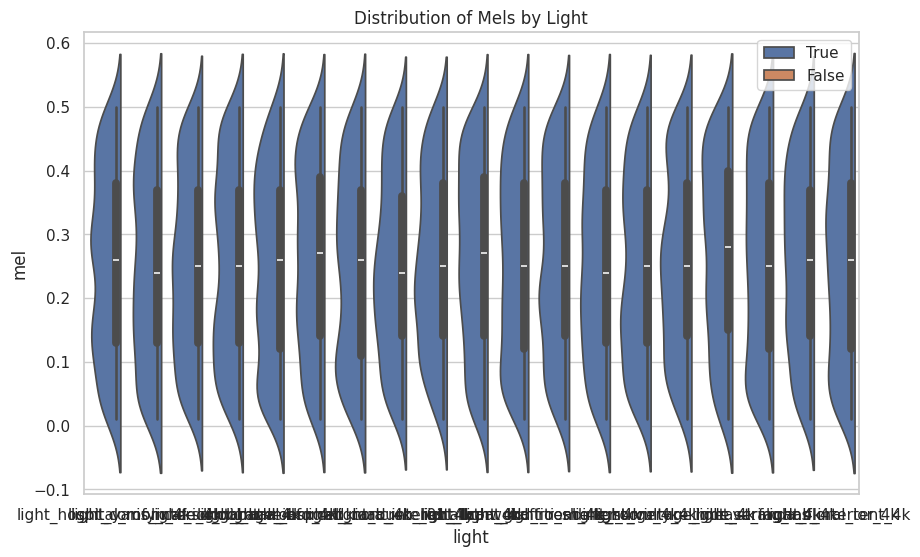

In [225]:
# plot the distribution of mels by light
plt.figure(figsize=(10, 6))
sns.violinplot(x='light', y='mel', data=df, hue=True, hue_order=[True, False], split=True)
plt.title('Distribution of Mels by Light')

Linear calibration of Bevan et al. estimation

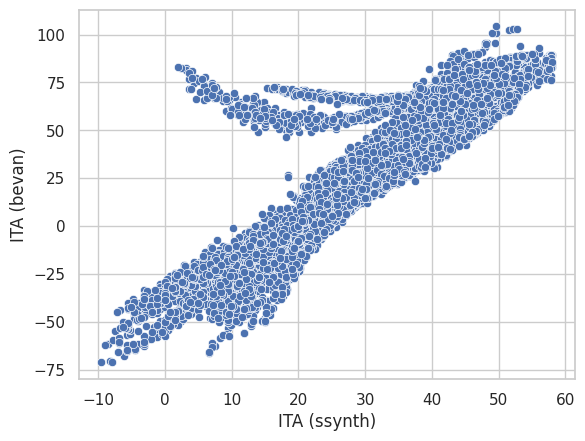

                            OLS Regression Results                            
Dep. Variable:             ita_ssynth   R-squared:                       0.725
Model:                            OLS   Adj. R-squared:                  0.725
Method:                 Least Squares   F-statistic:                 2.633e+04
Date:                Tue, 11 Mar 2025   Prob (F-statistic):               0.00
Time:                        11:11:35   Log-Likelihood:                -33166.
No. Observations:               10000   AIC:                         6.634e+04
Df Residuals:                    9998   BIC:                         6.635e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         20.4225      0.084    243.067      0.0

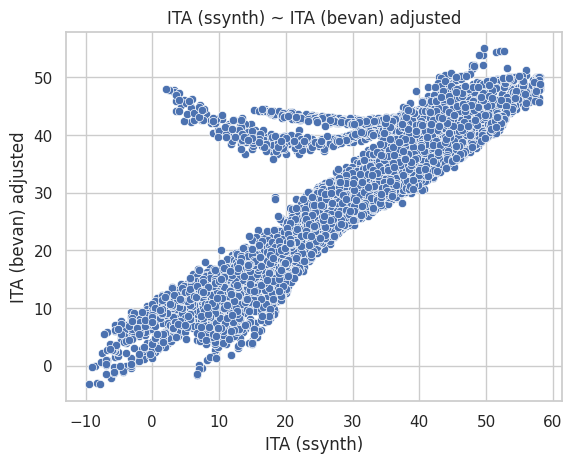

In [226]:
# plot bevan_ita vs ssynth_ita
sns.scatterplot(x='ita_ssynth', y='ita_bevan', data=df)
plt.xlabel('ITA (ssynth)')
plt.ylabel('ITA (bevan)')
plt.show()

# predict ssynth_ita based on bevan_ita
X = df[['ita_bevan']]
X = sm.add_constant(X)
y = df['ita_ssynth']
model = sm.OLS(y, X).fit()
print(model.summary())

# predictions
df['ita_bevan_adjusted'] = model.predict(X)

# plot the relationship
sns.scatterplot(x='ita_ssynth', y='ita_bevan_adjusted', data=df)
plt.xlabel('ITA (ssynth)')
plt.ylabel('ITA (bevan) adjusted')
plt.title('ITA (ssynth) ~ ITA (bevan) adjusted')
plt.show()

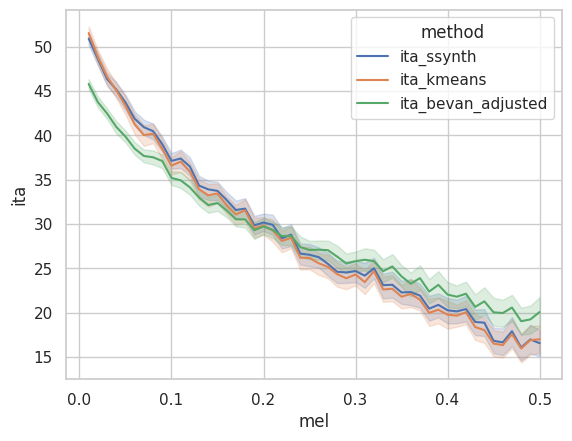

In [227]:
# plot relationship between mel and ita calculations
# methods: ita_ssynth, ita_kmeans, ita_bevan

# melt, ignoring light
df_melt = df.melt(id_vars=['file', 'mel'], value_vars=['ita_ssynth', 'ita_kmeans', 'ita_bevan_adjusted'], var_name='method', value_name='ita')
df_melt.head()

# line plot with confidence intervals
sns.set(style='whitegrid')
sns.lineplot(x='mel', y='ita', hue='method', data=df_melt)
plt.show()

In [228]:
import statsmodels.api as sm

y_names = ['ita_ssynth', 'ita_kmeans', 'ita_bevan_adjusted']
r2_mel = {}
r2_mel_light = {}

for y_name in y_names:
  X = df[['mel']]
  X = sm.add_constant(X)
  y = df[y_name]
  model = sm.OLS(y, X).fit()
  r2_mel[y_name] = model.rsquared

  X = df[['mel', 'light']]
  X = pd.get_dummies(X, drop_first=True)
  X = sm.add_constant(X)
  X = X.astype(float)
  y = df[y_name]
  model = sm.OLS(y, X).fit()
  r2_mel_light[y_name] = model.rsquared

print('ita ~ mel', r2_mel)
print('ita ~ mel + light', r2_mel_light)
# diffs
for y_name in y_names:
  print(y_name, 'delta R^2', r2_mel_light[y_name] - r2_mel[y_name])

ita ~ mel {'ita_ssynth': 0.49715188470448357, 'ita_kmeans': 0.4661684565591375, 'ita_bevan_adjusted': 0.3890335906480955}
ita ~ mel + light {'ita_ssynth': 0.7220571854558107, 'ita_kmeans': 0.6779094480240848, 'ita_bevan_adjusted': 0.6946141489334634}
ita_ssynth delta R^2 0.2249053007513271
ita_kmeans delta R^2 0.2117409914649473
ita_bevan_adjusted delta R^2 0.3055805582853679


0.7220571854558107


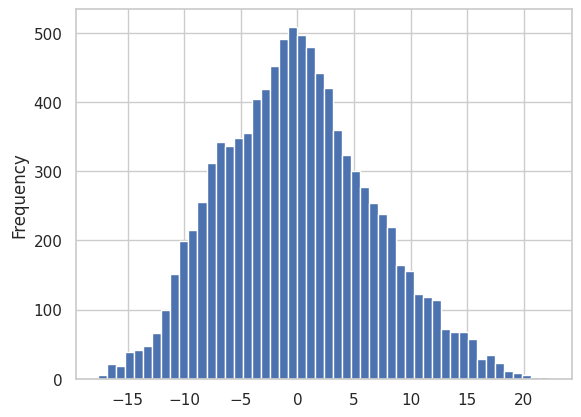

In [229]:
# R^2 with light
X = df[['mel', 'light']]
X = pd.get_dummies(X, drop_first=True)
X = sm.add_constant(X)
X = X.astype(float)
y = df['ita_ssynth']
model = sm.OLS(y, X).fit()

# print just the R^2
print(model.rsquared)

# check residuals
model.resid.plot(kind='hist', bins=50)
plt.show()

Analyze regression NN results

In [230]:
nn_df = pd.read_csv('mel_regression_test_results.csv')
nn_df.head() # columns: mel, pred, file

,mel,pred,file
0,0.04,0.034236,data/output_10k/output/skin_000/hairModel_000/...
1,0.16,0.168982,data/output_10k/output/skin_000/hairModel_015/...
2,0.29,0.281551,data/output_10k/output/skin_000/hairModel_018/...
3,0.22,0.194456,data/output_10k/output/skin_000/hairModel_019/...
4,0.07,0.072566,data/output_10k/output/skin_000/hairModel_044/...


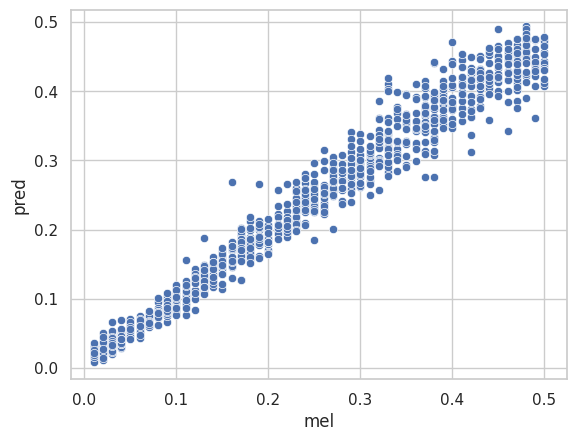

In [231]:
# plot correlation between mel and pred
sns.scatterplot(x='mel', y='pred', data=nn_df)
plt.show()

In [232]:
# merge df and nn_df
df = df.merge(nn_df[['file', 'pred']], on='file')
df = df.rename(columns={'pred': 'mel_pred'})
df.head()

,file,mel,ita_ssynth,ita_kmeans,ita_bevan,light,ita_bevan_adjusted,mel_pred
0,data/output_10k/output/skin_010/hairModel_097/...,0.31,19.608441,18.970408,6.859310,light_bush_restaurant_4k,22.699452,0.287060
1,data/output_10k/output/skin_010/hairModel_053/...,0.50,26.565051,26.119756,10.849855,light_surgery_4k,24.024097,0.438345
2,data/output_10k/output/skin_010/hairModel_087/...,0.09,43.830861,43.479230,46.474215,light_lythwood_room_4k,35.849450,0.103693
3,data/output_10k/output/skin_010/hairModel_082/...,0.49,22.221811,22.344767,0.259217,light_st_fagans_interior_4k,20.508580,0.436930
4,data/output_10k/output/skin_010/hairModel_005/...,0.05,48.477787,46.468801,55.922609,light_lythwood_room_4k,38.985804,0.062635


<Axes: xlabel='mel', ylabel='ita_ssynth'>

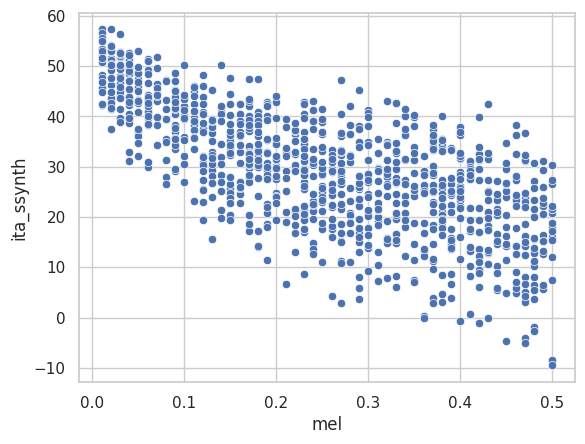

In [233]:
# plot relationship between mel and ita_ssnyth
sns.scatterplot(x='mel', y='ita_ssynth', data=df)

In [234]:
# model ita as a linear function of mel, via ita_ssynth ~ mel
X = df[['mel']]
X = sm.add_constant(X)
y = df['ita_ssynth']
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             ita_ssynth   R-squared:                       0.498
Model:                            OLS   Adj. R-squared:                  0.497
Method:                 Least Squares   F-statistic:                     989.4
Date:                Tue, 11 Mar 2025   Prob (F-statistic):          1.87e-151
Time:                        11:11:38   Log-Likelihood:                -3580.0
No. Observations:                1000   AIC:                             7164.
Df Residuals:                     998   BIC:                             7174.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         44.6239      0.556     80.219      0.000      43.532      45.715
mel          -60.7021      1.930    -31.455      0.000     -64.489     -56.915
==============================================================================
Omnibus:                       16.935   Durbin-Watson:                   1.301
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.408
Skew:                          -0.311   Prob(JB):                     0.000166
Kurtosis:                       2.826   Cond. No.                         7.47
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

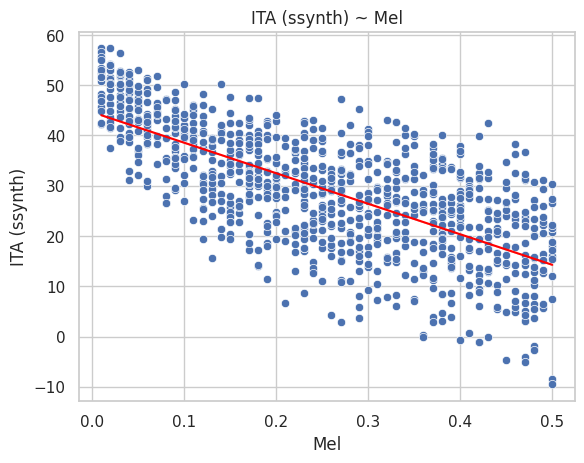

In [235]:
# plot the model
sns.scatterplot(x='mel', y='ita_ssynth', data=df)
sns.lineplot(x='mel', y=model.predict(X), color='red', data=df)
plt.xlabel('Mel')
plt.ylabel('ITA (ssynth)')
plt.title('ITA (ssynth) ~ Mel')
plt.show()

In [236]:
# now predict itas based on mel_pred
# ita_ssynth = mel_pred * coef + intercept
df['ita_pred'] = model.predict(sm.add_constant(df[['mel_pred']]))
df.head()

,file,mel,ita_ssynth,ita_kmeans,ita_bevan,light,ita_bevan_adjusted,mel_pred,ita_pred
0,data/output_10k/output/skin_010/hairModel_097/...,0.31,19.608441,18.970408,6.859310,light_bush_restaurant_4k,22.699452,0.287060,27.198750
1,data/output_10k/output/skin_010/hairModel_053/...,0.50,26.565051,26.119756,10.849855,light_surgery_4k,24.024097,0.438345,18.015426
2,data/output_10k/output/skin_010/hairModel_087/...,0.09,43.830861,43.479230,46.474215,light_lythwood_room_4k,35.849450,0.103693,38.329523
3,data/output_10k/output/skin_010/hairModel_082/...,0.49,22.221811,22.344767,0.259217,light_st_fagans_interior_4k,20.508580,0.436930,18.101331
4,data/output_10k/output/skin_010/hairModel_005/...,0.05,48.477787,46.468801,55.922609,light_lythwood_room_4k,38.985804,0.062635,40.821789


<Axes: xlabel='ita_ssynth', ylabel='ita_pred'>

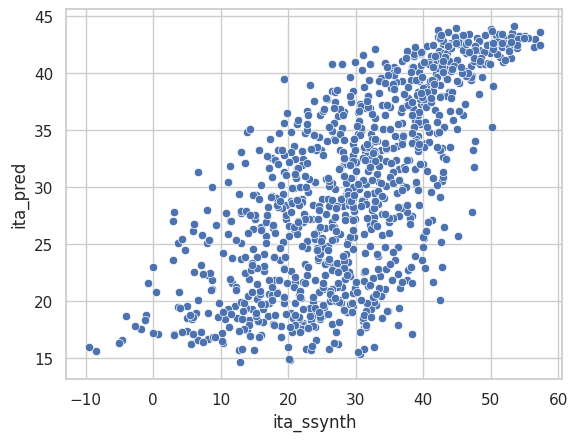

In [237]:
# plot the relationship between ita_ssynth and ita_pred
sns.scatterplot(x='ita_ssynth', y='ita_pred', data=df)

Text(0.5, 1.0, 'Bland Altman Plot')

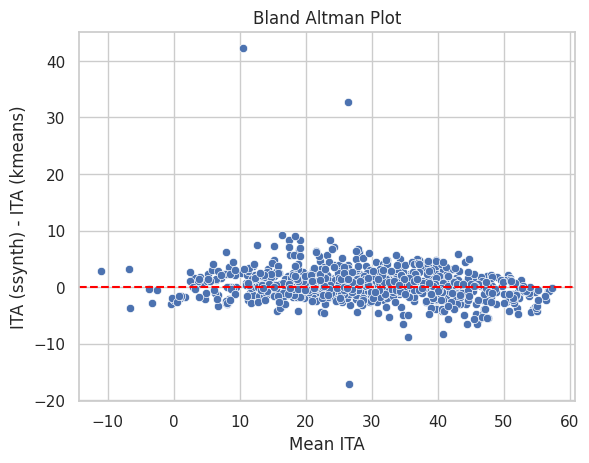

In [238]:
# bland altman plot of ita_ssnyth and ita_kmeans
df['diff_kmeans'] = df['ita_ssynth'] - df['ita_kmeans']
df['mean_kmeans'] = (df['ita_ssynth'] + df['ita_kmeans']) / 2
sns.scatterplot(x='mean_kmeans', y='diff_kmeans', data=df)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Mean ITA')
plt.ylabel('ITA (ssynth) - ITA (kmeans)')
plt.title('Bland Altman Plot')


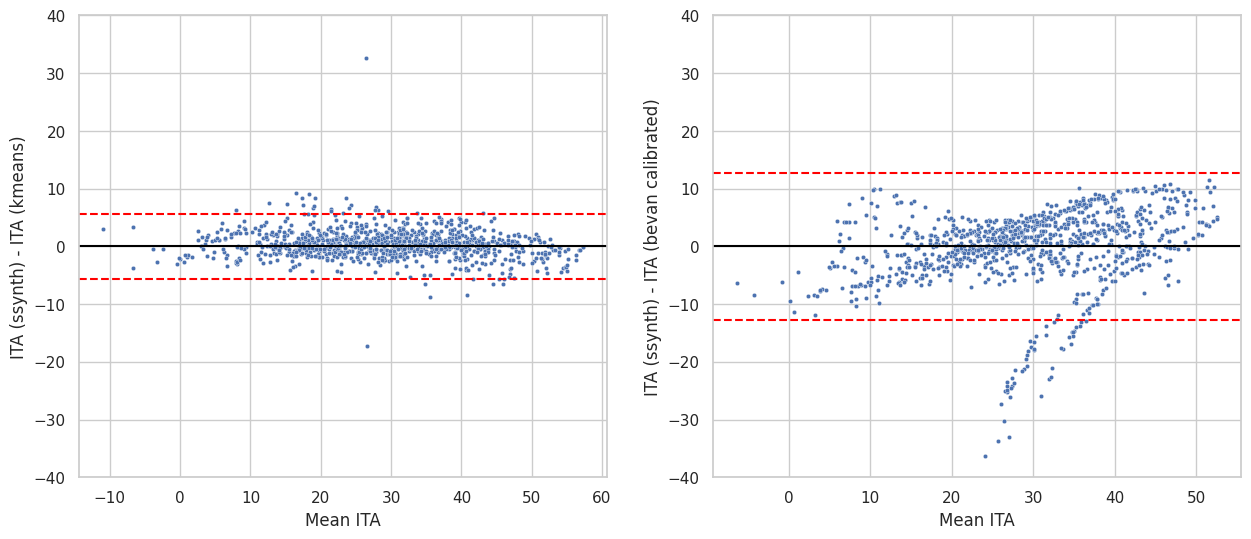

In [239]:
plt.subplots(1, 2, figsize=(15, 6))
plt.subplot(1, 2, 1)
df['diff_kmeans'] = df['ita_ssynth'] - df['ita_kmeans']
df['mean_kmeans'] = (df['ita_ssynth'] + df['ita_kmeans']) / 2
sns.scatterplot(x='mean_kmeans', y='diff_kmeans', data=df, s=10)
plt.ylim(-40, 40)
plt.axhline(0, color='black')
plt.xlabel('Mean ITA')
plt.ylabel('ITA (ssynth) - ITA (kmeans)')
# 95% CI
plt.axhline(1.96 * df['diff_kmeans'].std(), color='red', linestyle='--')
plt.axhline(-1.96 * df['diff_kmeans'].std(), color='red', linestyle='--')

plt.subplot(1, 2, 2)
df['diff_bevan'] = df['ita_ssynth'] - df['ita_bevan_adjusted']
df['mean_bevan'] = (df['ita_ssynth'] + df['ita_bevan_adjusted']) / 2
sns.scatterplot(x='mean_bevan', y='diff_bevan', data=df, s=10)
plt.axhline(0, color='black')
plt.xlabel('Mean ITA')
plt.ylim(-40, 40)
plt.ylabel('ITA (ssynth) - ITA (bevan calibrated)')
# 95% CI
plt.axhline(1.96 * df['diff_bevan'].std(), color='red', linestyle='--')
plt.axhline(-1.96 * df['diff_bevan'].std(), color='red', linestyle='--')

In [240]:
from get_ita_for_data import bin_ITA

df['bevan_fp'] = df['ita_bevan_adjusted'].apply(bin_ITA).astype('category')
df['ssynth_fp'] = df['ita_ssynth'].apply(bin_ITA).astype('category')
df['kmeans_fp'] = df['ita_kmeans'].apply(bin_ITA).astype('category')

print(df['bevan_fp'].value_counts())
# bevan_fp is missing category 1
df['bevan_fp'] = df['bevan_fp'].cat.add_categories(1)
# reorder so that 1 is first
df['bevan_fp'] = df['bevan_fp'].cat.reorder_categories([1, 2, 3, 4, 5, 6])
df['bevan_fp'] = df['bevan_fp'].fillna(1)
print(df['bevan_fp'].value_counts())

bevan_fp
3    392
4    270
2    168
5    122
6     48
Name: count, dtype: int64
bevan_fp
3    392
4    270
2    168
5    122
6     48
1      0
Name: count, dtype: int64


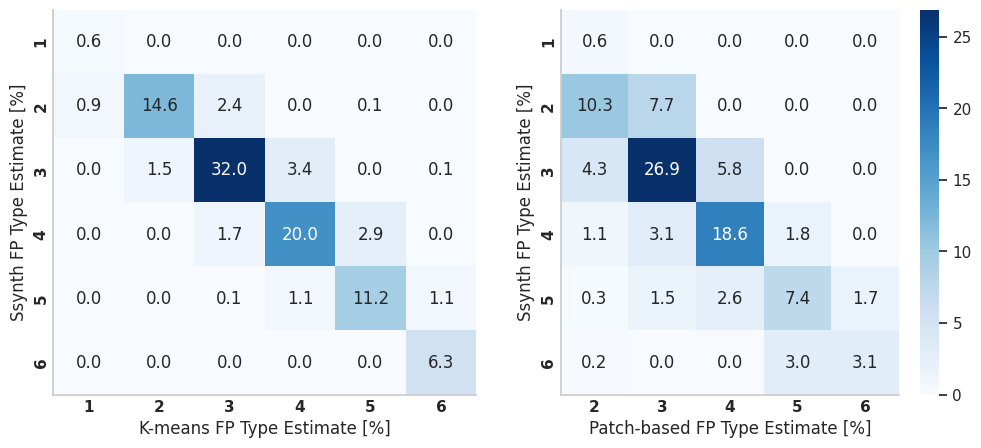

In [241]:
plt.subplots(1, 2, figsize=(12, 5))
plt.subplot(121)
# confusion matrix between ssynth_fp and kmeans_fp
confusion_matrix = pd.crosstab(df['ssynth_fp'], df['kmeans_fp'])
# normalize
confusion_matrix = confusion_matrix / confusion_matrix.sum().sum()
confusion_matrix *= 100
# plot the confusion matrix
sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='.1f', cbar=False)
# remove color bar
plt.xlabel('K-means FP Type Estimate [%]')
plt.ylabel('Ssynth FP Type Estimate [%]')
# remove tick lines
plt.tick_params(axis='both', which='both', length=0)
# make labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
# add border
plt.gca().spines['bottom'].set_visible(True)
plt.gca().spines['left'].set_visible(True)

plt.subplot(122)
confusion_matrix = pd.crosstab(df['ssynth_fp'], df['bevan_fp'])
# normalize
confusion_matrix = confusion_matrix / confusion_matrix.sum().sum()
confusion_matrix *= 100
# plot the confusion matrix
sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='.1f')
plt.xlabel('Patch-based FP Type Estimate [%]')
plt.ylabel('Ssynth FP Type Estimate [%]')
# remove tick lines
plt.tick_params(axis='both', which='both', length=0)
# make labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
# add border
plt.gca().spines['bottom'].set_visible(True)
plt.gca().spines['left'].set_visible(True)

In [256]:
# get mel range per ssynth_fp
mean_mel = df.groupby('ssynth_fp')['mel'].mean()
std_mel = df.groupby('ssynth_fp')['mel'].std()
mel_range = pd.concat([mean_mel, std_mel], axis=1)
mel_range.columns = ['mean', 'std']
# get mid points between each category
mel_range['mid'] = mel_range['mean'].rolling(2).mean()
mel_range = mel_range.dropna()
display(mel_range)

def bin_FP_by_mel(mel):
  # find the category that mel falls into
  # if mel is less than the first mid point, return the first category
  if mel < mel_range['mid'].iloc[0]:
    return 1
  # if mel is greater than the last mid point, return the last category
  if mel > mel_range['mid'].iloc[-1]:
    return mel_range.index[-1]
  # find the category that mel falls into
  for i in range(len(mel_range) - 1):
    if mel_range['mid'].iloc[i] <= mel < mel_range['mid'].iloc[i + 1]:
      return mel_range.index[i]
  return None

df['mel_fp'] = df['mel'].apply(bin_FP_by_mel).astype('category')
df['mel_pred_fp'] = df['mel_pred'].apply(bin_FP_by_mel).astype('category')
print(df['mel_fp'].value_counts())

print(len(df))

/tmp/ipykernel_2622051/2682128765.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_mel = df.groupby('ssynth_fp')['mel'].mean()
/tmp/ipykernel_2622051/2682128765.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  std_mel = df.groupby('ssynth_fp')['mel'].std()


,mean,std,mid
ssynth_fp,,,
2,0.081167,0.078735,0.048083
3,0.228865,0.114021,0.155016
4,0.313293,0.111367,0.271079
5,0.360074,0.095022,0.336683
6,0.406032,0.073365,0.383053


mel_fp
3    263
6    222
2    204
4    123
5     96
1     92
Name: count, dtype: int64
1000


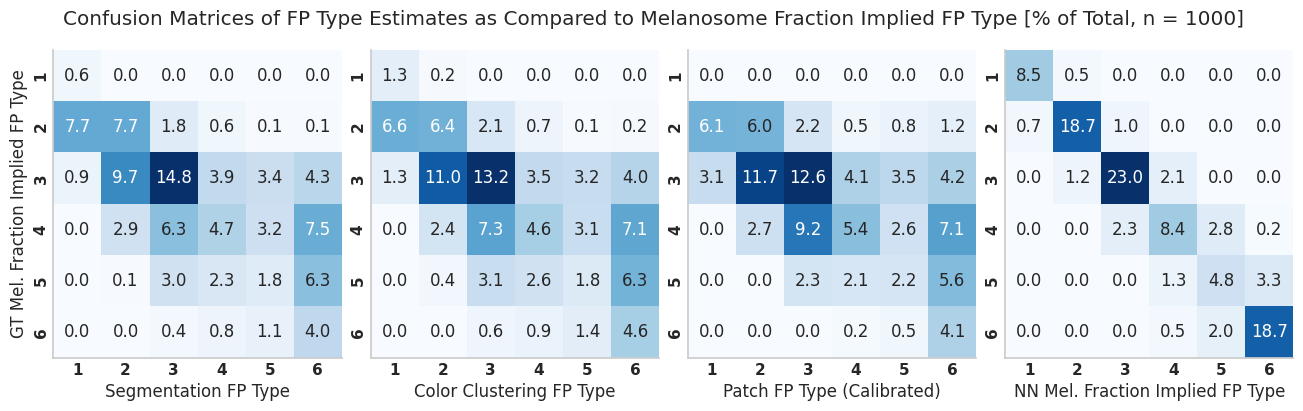

In [260]:
plt.subplots(1, 4, figsize=(16, 4))
plt.subplot(141)
# confusion matrix between ssynth_fp and kmeans_fp
confusion_matrix = pd.crosstab(df['ssynth_fp'], df['mel_fp'])
# normalize
confusion_matrix = confusion_matrix / confusion_matrix.sum().sum()
confusion_matrix *= 100
# plot the confusion matrix
sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='.1f', cbar=False)
# remove color bar
plt.ylabel('GT Mel. Fraction Implied FP Type')
plt.xlabel('Segmentation FP Type')
# remove tick lines
plt.tick_params(axis='both', which='both', length=0)
# make labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
# add border
plt.gca().spines['bottom'].set_visible(True)
plt.gca().spines['left'].set_visible(True)

plt.subplot(142)
plt.suptitle('Confusion Matrices of FP Type Estimates as Compared to Melanosome Fraction Implied FP Type [% of Total, n = 1000]')
confusion_matrix = pd.crosstab(df['kmeans_fp'], df['mel_fp'])
# normalize
confusion_matrix = confusion_matrix / confusion_matrix.sum().sum()
confusion_matrix *= 100
# plot the confusion matrix
sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='.1f', cbar=False)
plt.ylabel('')
plt.xlabel('Color Clustering FP Type')
# remove tick lines
plt.tick_params(axis='both', which='both', length=0)
# make labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
# add border
plt.gca().spines['bottom'].set_visible(True)
plt.gca().spines['left'].set_visible(True)

plt.subplot(143)
confusion_matrix = pd.crosstab(df['bevan_fp'], df['mel_fp'], dropna=False)
# normalize
confusion_matrix = confusion_matrix / confusion_matrix.sum().sum()
confusion_matrix *= 100
# plot the confusion matrix
sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='.1f', cbar=False)
plt.ylabel('')
plt.xlabel('Patch FP Type (Calibrated)')
# remove tick lines
plt.tick_params(axis='both', which='both', length=0)
# make labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
# add border
plt.gca().spines['bottom'].set_visible(True)
plt.gca().spines['left'].set_visible(True)

plt.subplot(144)
confusion_matrix = pd.crosstab(df['mel_pred_fp'], df['mel_fp'])
# normalize
confusion_matrix = confusion_matrix / confusion_matrix.sum().sum()
confusion_matrix *= 100
# plot the confusion matrix
sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='.1f', cbar=False)
plt.ylabel('')
plt.xlabel('NN Mel. Fraction Implied FP Type')
# remove tick lines
plt.tick_params(axis='both', which='both', length=0)
# make labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
# add border
plt.gca().spines['bottom'].set_visible(True)
plt.gca().spines['left'].set_visible(True)

# set margins
plt.subplots_adjust(wspace=0.1)

In [262]:
# take mel_fp to be the ground truth and calculate classification metrics for bevan_fp, kmeans_fp, and mel_pred_fp

from sklearn.metrics import classification_report

# bevan_fp
print('Bevan FP')
print(classification_report(df['mel_fp'], df['bevan_fp']))

# kmeans_fp
print('Kmeans FP')
print(classification_report(df['mel_fp'], df['kmeans_fp']))

# mel_pred_fp
print('Mel Pred FP')
print(classification_report(df['mel_fp'], df['mel_pred_fp']))

Bevan FP
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        92
           2       0.36      0.29      0.32       204
           3       0.32      0.48      0.38       263
           4       0.20      0.44      0.27       123
           5       0.18      0.23      0.20        96
           6       0.85      0.18      0.30       222

    accuracy                           0.30      1000
   macro avg       0.32      0.27      0.25      1000
weighted avg       0.39      0.30      0.29      1000

Kmeans FP
              precision    recall  f1-score   support

           1       0.87      0.14      0.24        92
           2       0.40      0.31      0.35       204
           3       0.36      0.50      0.42       263
           4       0.19      0.37      0.25       123
           5       0.13      0.19      0.15        96
           6       0.61      0.21      0.31       222

    accuracy                           0.32      1000
   m

/home/marinbenc/miniconda3/envs/pt2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/marinbenc/miniconda3/envs/pt2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/marinbenc/miniconda3/envs/pt2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r